In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, quarter_plot, month_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid 
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data Preparation

In [4]:
#read csv file, set date as index
df = pd.read_csv('freiburg_residual_load.csv', sep = ';', index_col = 'Date', parse_dates = True)

In [6]:
#rename first column as 'residual_load' for easier calling
df.rename(columns = {df.columns[1]: 'residual_load'}, inplace = True)

In [8]:
#view dataframe
df

,Total (grid load) [MWh] Calculated resolutions,residual_load,Hydro pumped storage [MWh] Calculated resolutions,Air_Temperature,Relative_Humidity,Visibility,Air_Pressure_at_Station_Height,Cloud_Cover,Daily_Precipitation_Height,Snow_Height_Daily_Value,Global_Radiation,Vapor_Pressure,Dew_Point_Temperature,Wind_Direction,Wind_Strength
Date,,,,,,,,,,,,,,,
2015-01-01,126180.75,125328.75,13463.50,-3.50,96.00,3.67,1007.77,4.33,0.0,4.0,NaN,4.53,-3.70,25.33,2.00
2015-01-02,147068.75,141690.00,13661.25,1.13,79.67,7.67,1005.73,6.67,2.1,3.0,NaN,5.33,-0.20,20.00,2.67
2015-01-03,141413.50,136265.25,12602.25,5.80,93.67,6.67,997.60,8.00,6.4,0.0,NaN,8.80,5.30,14.67,3.00
2015-01-04,132434.75,125728.25,11493.00,3.03,81.67,8.33,1005.30,3.33,0.0,0.0,NaN,6.20,1.83,26.67,2.00
2015-01-05,152600.50,143883.50,14395.50,-0.80,83.33,6.33,1004.57,2.00,0.0,0.0,NaN,4.70,-1.83,17.33,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,193140.50,175436.25,8673.75,5.00,79.75,8.50,998.38,7.75,0.0,0.0,43.61,7.00,3.58,29.00,1.75
2025-02-01,157897.25,123080.75,8723.25,1.42,80.25,7.75,999.32,4.00,0.0,0.0,68.80,5.40,0.15,19.00,1.75
2025-02-02,153864.00,132318.50,9677.50,2.95,75.25,8.00,995.65,8.00,0.0,0.0,57.14,5.70,1.35,23.00,1.75


In [10]:
#dataframe to only include residual load
df = df.iloc[:,[1]]

In [12]:
#resample dataframe according to different time frames
df_monthly = df.resample('M').mean()
df_weekly = df.resample('W').mean()
df_daily = df

In [14]:
#set the frequency of df_daily to 'daily'
df_daily = df_daily.asfreq('D')

In [156]:
#check if daily frequency set been set successfully
df_daily.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2025-01-26', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31', '2025-02-01', '2025-02-02',
               '2025-02-03', '2025-02-04'],
              dtype='datetime64[ns]', name='Date', length=3688, freq='D')

# Data Analysis

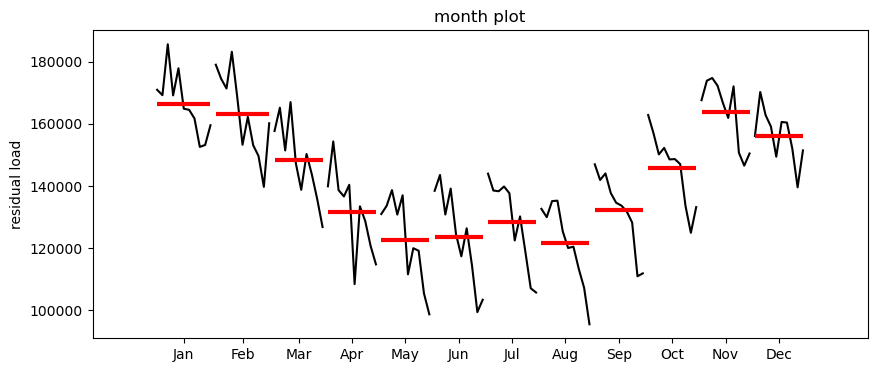

In [18]:
#month plot to investigate seasonality and trend 
fig, ax = plt.subplots(figsize = (10,4))
month_plot(df_daily['residual_load'].resample('M').mean(), ylabel = 'residual load', ax = ax)
plt.title('month plot')
plt.show()

- Each black line represent a specific month for all years in dataset
- The red line represents the mean residual load for categorised month across all years
- We can observe that residual load is decreasing across the years
- Peak residual load at January and December

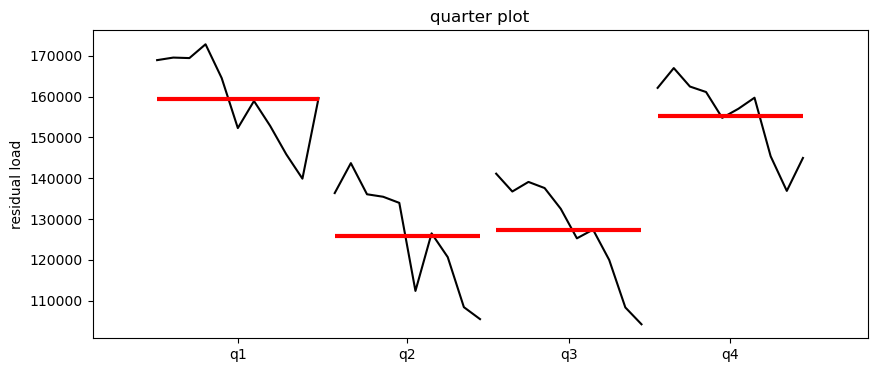

In [20]:
#quarter plot to investigate seasonality and trend
fig, ax = plt.subplots(figsize = (10,4))
quarter_plot(df_daily['residual_load'].resample('Q').mean(), ylabel = 'residual load', ax = ax)
plt.title('quarter plot')
plt.show()

- shows the same information as the monthly plot above but in a quarterly timeframe 
- observation is consistent with the observation above

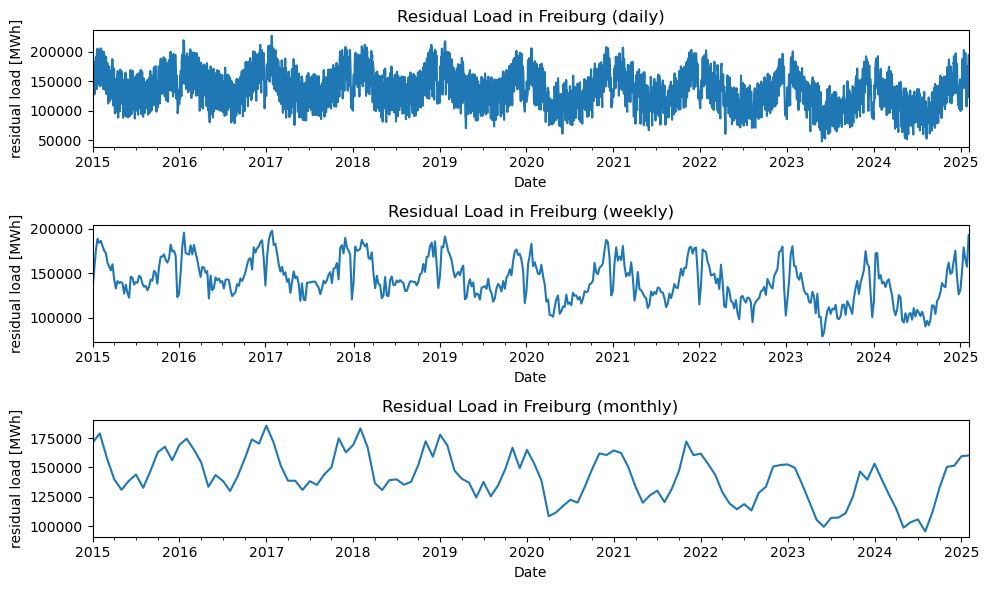

In [22]:
#residual load in different time frames
fig, ax = plt.subplots(3, 1, figsize = (10,6))
df_daily['residual_load'].plot(title = 'Residual Load in Freiburg (daily)', ylabel = 'residual load [MWh]', ax = ax[0])
df_weekly['residual_load'].plot(title = 'Residual Load in Freiburg (weekly)', ylabel = 'residual load [MWh]', ax = ax[1])
df_monthly['residual_load'].plot(title = 'Residual Load in Freiburg (monthly)', ylabel = 'residual load [MWh]', ax = ax[2])
plt.tight_layout()
plt.show()

In [31]:
#seasonal decomposition setup
decomposition_daily = seasonal_decompose(df_daily['residual_load'], model = 'mul', period = 365)

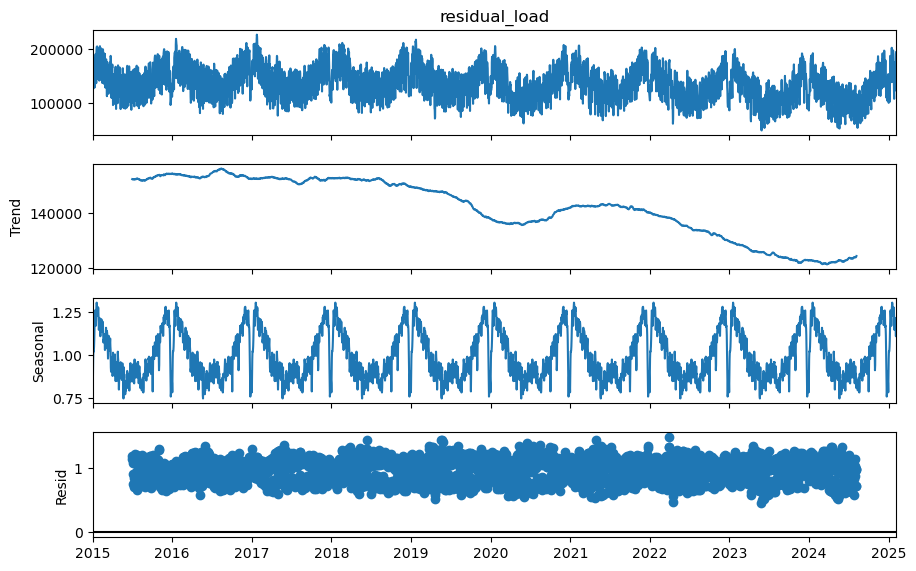

In [26]:
#daily seasonal decomposition 
decomposition_daily.plot().set_size_inches(10,6)
plt.show()

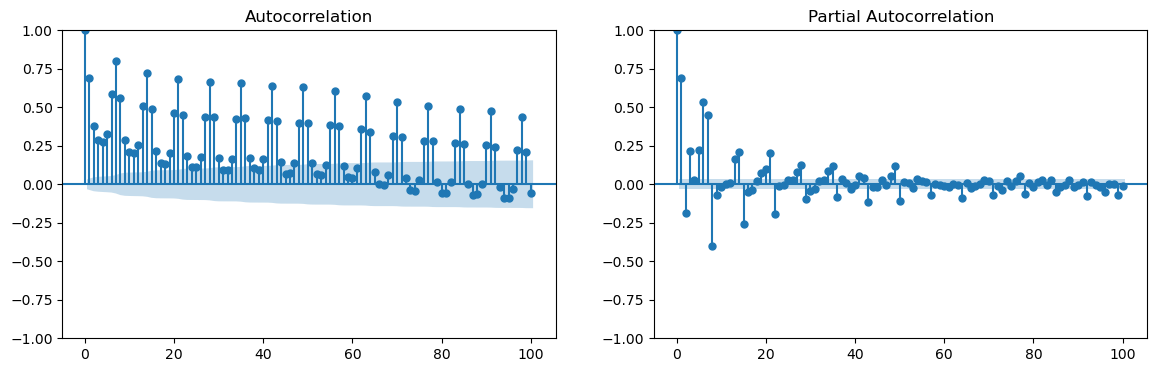

In [24]:
#PACF (Partial Autocorrelation Function) and ACF (Autocorrelation Fuction) plot
fig, ax = plt.subplots(1, 2, figsize  = (14,4))
plot_acf(df_daily['residual_load'], lags = 100, ax = ax[0])
plot_pacf(df_daily['residual_load'], lags = 100, ax = ax[1])
plt.show()

- Blue shaded region in the plots represents the confidence interval for statistical significance.
  - If a bar (lag) extends beyond the blue band, the autocorrelation at that lag is statistically significant.
  - If a bar stays inside the blue band, the autocorrelation is not significant (likely just noise).
- ACF (Autocorrelation Function) measures the correlation between a time series and its lagged versions.
  - ACF helps find MA (moving average) order 'q'
  - ACF cuts off at 1 -> implies possible MR(1) or q = 1
- PACF (Partial Autocorrelation function) measures the correlation between a time series and its lagged versions after removing the effect of intermediate lags.
  - PACF helps find AR order 'p'
  - PACF cuts off at 1 -> implies possible AR(1) or p = 1

# User Defined Function

In [28]:
#plots the train, test and prediction data in a single graph
def model_prediction(train, test, prediction, title):
    plt.figure(figsize = (10,4))
    train.plot(label = 'train')
    test.plot(label = 'test')
    prediction.plot(label = 'prediction')
    plt.title(title)
    plt.ylabel('residual_load')
    plt.legend()
    plt.show()

    mae = mean_absolute_error(prediction, test)
    rmse = mean_squared_error(prediction, test, squared = False)
    r2 = r2_score(prediction, test)
    mape = mean_absolute_percentage_error(prediction, test)
    
    print(f'AME:{mae:.2f}')
    print(f'RMSE:{rmse:.2f}')
    print(f'R2:{r2:.2f}')
    print(f'MAPE:{100*mape:.2f}%')

# Test for Stationarity

- Stationarity is a fundamental concept in time series forecasting that ensures the statistical properties of a dataset remain constant over time.
- This stability is crucial for building reliable models (like ARIMA) because most algorithms assume the data follows consistent patterns.
- Key properties of stationary time series
  - constant mean (no updward/downward trend)
  - constant variance (volatility doesn't change over time)
  - constant autocorrelation (relationships between lagged observations don't change)
- Stationarity can be tested with ADFuller test

In [60]:
#Differencing the subsequent residual load value from the previous residual load value
#This will achieve better stationarity
df['residual_load_diff'] = df['residual_load'].diff().dropna()

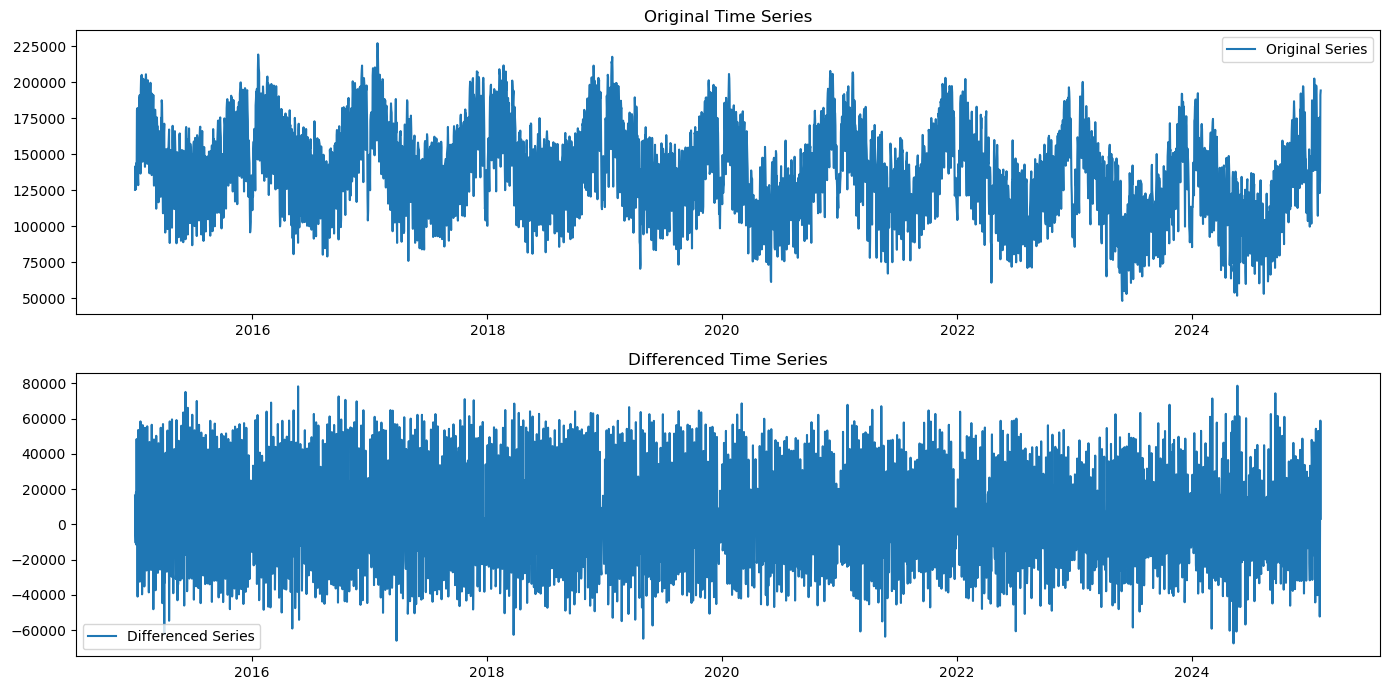

In [62]:
#plot orginal time series and differenced time series
plt.figure(figsize = (14,7))
plt.subplot(2, 1, 1) #2 rows, 1 column, 1st subplot
plt.plot(df['residual_load'], label = 'Original Series')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2) #2nd subplot
plt.plot(df['residual_load_diff'], label = 'Differenced Series')
plt.title('Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
#test for stationarity with ADFuller test
#if value of p < 0.05, the time series is stationary, else it is not stationary 
result = adfuller(df['residual_load'])
print(f'p-value(residual load): {result[1]}')
if result[1] > 0.05:
    print('Evidence suggests that the time series is not stationary.')
else:
    print('Evidence suggests that the time series is stationary.')
    
print('\n')

result = adfuller(df['residual_load_diff'].dropna())
print(f'p-value(residual load diff): {result[1]}')
if result[1] > 0.05:
    print('Evidence suggests that the time series is not stationary.')
else:
    print('Evidence suggests that the time series is stationary.')

p-value(residual load): 1.1704932382827433e-05
Evidence suggests that the time series is stationary.


p-value(residual load diff): 1.0890843799261097e-26
Evidence suggests that the time series is stationary.


# Train-test split

In [22]:
#daily train-test split
#these 4 train-test splits will be used for 7 day forecasting only
#all data except for the last 7 days is used for training; last 7 days for testing  
train_daily_7, test_daily_7 = df_daily.iloc[:-7, 0], df_daily.iloc[-7:, 0]
#random test 1 
train_daily_random_test_7_1, test_daily_random_test_7_1 = df_daily.iloc[:-100, 0], df_daily.iloc[-100:-93, 0]
#random test 2
train_daily_random_test_7_2, test_daily_random_test_7_2 = df_daily.iloc[:-250, 0], df_daily.iloc[-250:-243, 0]
#random test 3
train_daily_random_test_7_3, test_daily_random_test_7_3 = df_daily.iloc[:-410, 0], df_daily.iloc[-410:-403, 0]

#these train-test splits will be used for 30 day forecasting only
#all data except for the last 7 days is used for training; last 7 days for testing  
train_daily_30, test_daily_30 = df_daily.iloc[:-30, 0], df_daily.iloc[-30:, 0]
#random test 1 
train_daily_random_test_30_1, test_daily_random_test_30_1 = df_daily.iloc[:-100, 0], df_daily.iloc[-100:-70, 0]
#random test 2
train_daily_random_test_30_2, test_daily_random_test_30_2 = df_daily.iloc[:-250, 0], df_daily.iloc[-250:-220, 0]
#random test 3
train_daily_random_test_30_3, test_daily_random_test_30_3 = df_daily.iloc[:-410, 0], df_daily.iloc[-410:-380, 0]

# Model training and Forecasting using autoarima

### - Autoarima finds the best parameters for the model automatically`
### - Each dataset might have different best parameters as seen below 

## 7 days forecasts

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3681
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -40358.939
Date:                           Sat, 29 Mar 2025   AIC                          80727.878
Time:                                   09:06:26   BIC                          80758.931
Sample:                               01-01-2015   HQIC                         80738.932
                                    - 01-28-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    580.6405     58.481      9.929      0.000     466.020     695.261
ma.L1         -0.2225      0.013    -16.737

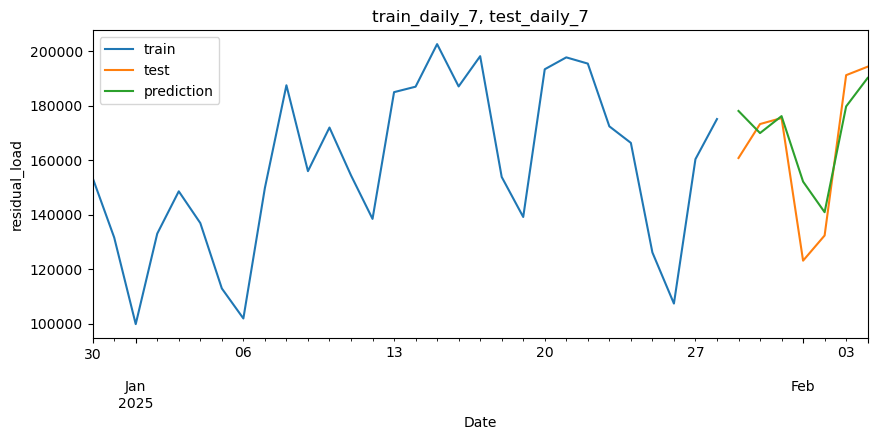

AME:10638.00
RMSE:14008.87
R2:0.22
MAPE:6.54%


In [30]:
#model training and forecasting
model_sarima_daily_7 = auto_arima(train_daily_7, m = 7)
print(model_sarima_daily_7.summary())

#predict the next seven days
prediction_sarima_daily_7 = model_sarima_daily_7.predict(n_periods = len(test_daily_7))

#model prediction plot
model_prediction(train_daily_7[-30:], test_daily_7, prediction_sarima_daily_7, 'train_daily_7, test_daily_7')

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3588
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -39718.236
Date:                           Sat, 29 Mar 2025   AIC                          79442.472
Time:                                   11:24:16   BIC                          79461.027
Sample:                               01-01-2015   HQIC                         79449.085
                                    - 10-27-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.4285      0.010     41.451      0.000       0.408       0.449
ar.S.L14       0.4148      0.011     36.619

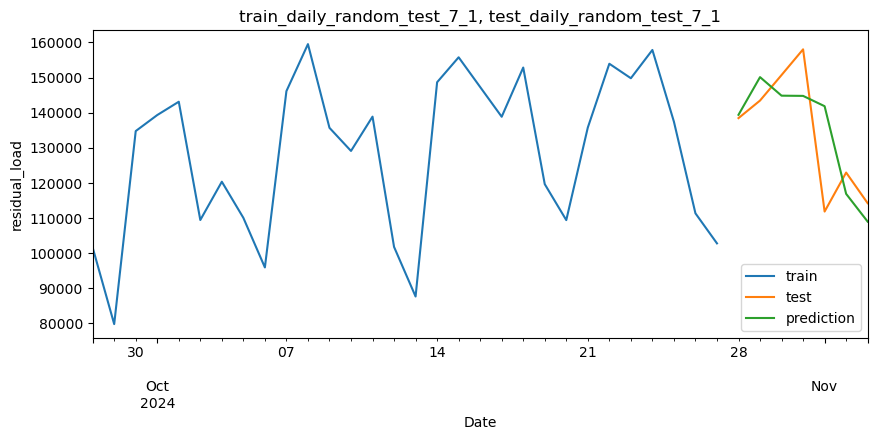

AME:9721.21
RMSE:13199.02
R2:0.18
MAPE:7.07%


In [34]:
#model training and forecasting
model_sarima_daily_7_1 = auto_arima(train_daily_random_test_7_1, m = 7)
print(model_sarima_daily_7_1.summary())


#predict the next seven days
prediction_sarima_daily_7_1 = model_sarima_daily_7_1.predict(n_periods = len(test_daily_random_test_7_1))

#model prediction plot
model_prediction(train_daily_random_test_7_1[-30:], test_daily_random_test_7_1, prediction_sarima_daily_7_1, 'train_daily_random_test_7_1, test_daily_random_test_7_1')

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3438
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -38047.444
Date:                           Sat, 29 Mar 2025   AIC                          76100.888
Time:                                   11:25:12   BIC                          76119.315
Sample:                               01-01-2015   HQIC                         76107.471
                                    - 05-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.4269      0.011     40.608      0.000       0.406       0.448
ar.S.L14       0.4194      0.012     35.956

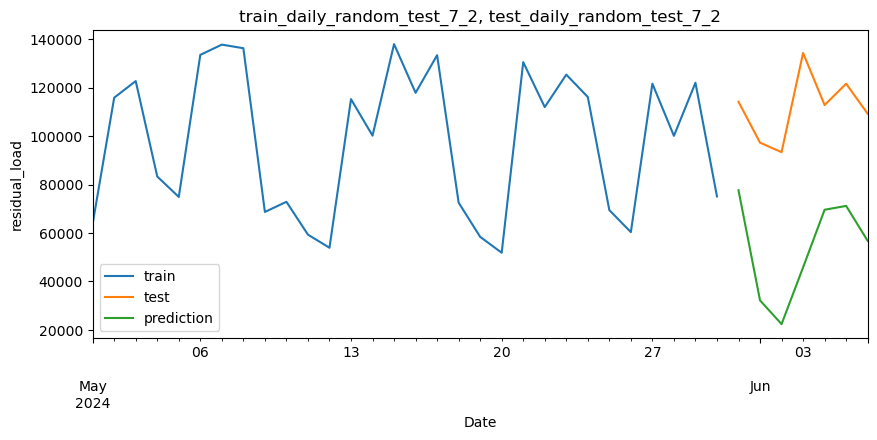

AME:58189.54
RMSE:60498.20
R2:-8.68
MAPE:140.69%


In [36]:
#model training and forecasting
model_sarima_daily_7_2 = auto_arima(train_daily_random_test_7_2, m = 7)
print(model_sarima_daily_7_2.summary())

#predict the next seven days
prediction_sarima_daily_7_2 = model_sarima_daily_7_2.predict(n_periods = len(test_daily_random_test_7_2))

#model prediction plot
model_prediction(train_daily_random_test_7_2[-30:], test_daily_random_test_7_2, prediction_sarima_daily_7_2, 'train_daily_random_test_7_2, test_daily_random_test_7_2')

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 3278
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -36354.682
Date:                             Sat, 29 Mar 2025   AIC                          72721.365
Time:                                     11:26:20   BIC                          72757.933
Sample:                                 01-01-2015   HQIC                         72734.459
                                      - 12-22-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -36.5961     48.069     -0.761      0.446    -130.810      57.617
ar.L1         -0.1175      

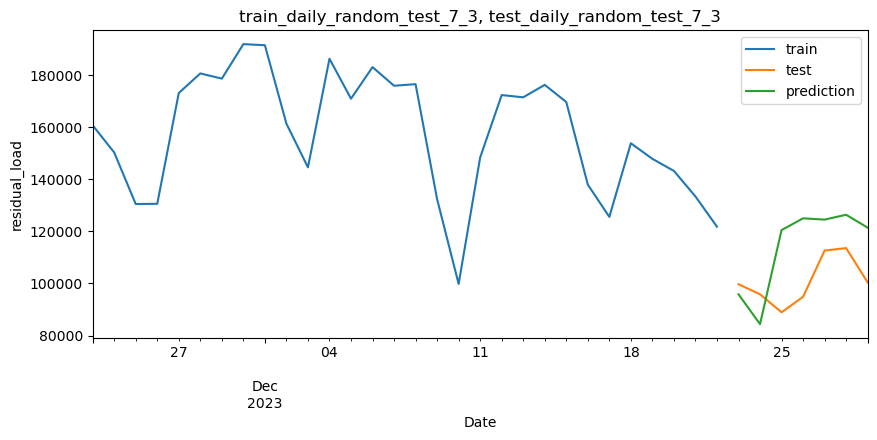

AME:17562.05
RMSE:20023.55
R2:-0.66
MAPE:15.01%


In [38]:
#model training and forecasting
model_sarima_daily_7_3 = auto_arima(train_daily_random_test_7_3, m = 7)
print(model_sarima_daily_7_3.summary())

#predict the next seven days
prediction_sarima_daily_7_3 = model_sarima_daily_7_3.predict(n_periods = len(test_daily_random_test_7_3))

#model prediction plot
model_prediction(train_daily_random_test_7_3[-30:], test_daily_random_test_7_3, prediction_sarima_daily_7_3, 'train_daily_random_test_7_3, test_daily_random_test_7_3')

## 30 days Forecasts 

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 3658
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood              -40286.743
Date:                             Wed, 26 Mar 2025   AIC                          80583.487
Time:                                     13:12:13   BIC                          80614.509
Sample:                                 01-01-2015   HQIC                         80594.534
                                      - 01-05-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1361.7218    121.889     11.172      0.000    1122.823    1600.620
ar.S.L7        0.7677      

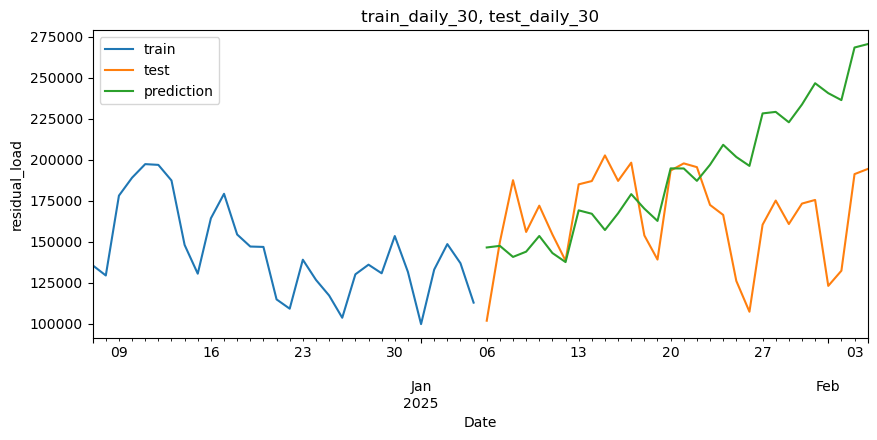

AME:41016.14
RMSE:52146.82
MAPE:19.96%


In [107]:
#model training and forecasting
model_sarima_daily_30 = auto_arima(train_daily_30, m = 7)
print(model_sarima_daily_30.summary())

#predict the next seven days
prediction_sarima_daily_30 = model_sarima_daily_30.predict(n_periods = len(test_daily_30))

#model prediction plot
model_prediction(train_daily_30[-30:], test_daily_30, prediction_sarima_daily_30, 'train_daily_30, test_daily_30')

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3588
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -39718.236
Date:                           Wed, 26 Mar 2025   AIC                          79442.472
Time:                                   13:15:41   BIC                          79461.027
Sample:                               01-01-2015   HQIC                         79449.085
                                    - 10-27-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.4285      0.010     41.451      0.000       0.408       0.449
ar.S.L14       0.4148      0.011     36.619

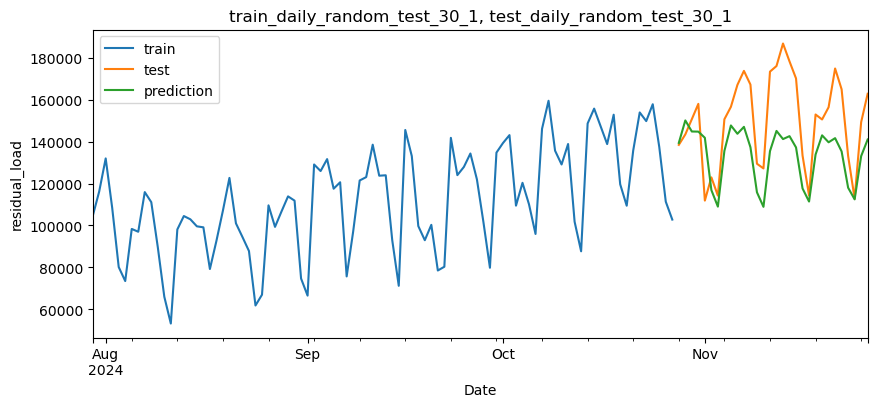

AME:18849.74
RMSE:22322.91
MAPE:13.86%


In [109]:
#model training and forecasting
model_sarima_daily_30_1 = auto_arima(train_daily_random_test_30_1, m = 7)
print(model_sarima_daily_30_1.summary())

#predict the next seven days
prediction_sarima_daily_30_1 = model_sarima_daily_30_1.predict(n_periods = len(test_daily_random_test_30_1))

#model prediction plot
model_prediction(train_daily_random_test_30_1[-90:], test_daily_random_test_30_1, prediction_sarima_daily_30_1, 'train_daily_random_test_30_1, test_daily_random_test_30_1')

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3438
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -38047.444
Date:                           Wed, 26 Mar 2025   AIC                          76100.888
Time:                                   13:16:45   BIC                          76119.315
Sample:                               01-01-2015   HQIC                         76107.471
                                    - 05-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.4269      0.011     40.608      0.000       0.406       0.448
ar.S.L14       0.4194      0.012     35.956

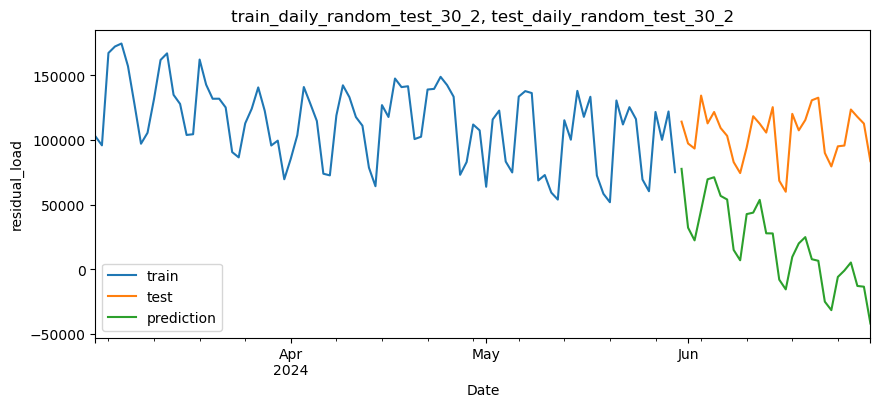

AME:85543.55
RMSE:89993.41
MAPE:921.41%


In [111]:
#model training and forecasting
model_sarima_daily_30_2 = auto_arima(train_daily_random_test_30_2, m = 7)
print(model_sarima_daily_30_2.summary())

#predict the next seven days
prediction_sarima_daily_30_2 = model_sarima_daily_30_2.predict(n_periods = len(test_daily_random_test_30_2))

#model prediction plot
model_prediction(train_daily_random_test_30_2[-90:], test_daily_random_test_30_2, prediction_sarima_daily_30_2, 'train_daily_random_test_30_2, test_daily_random_test_30_2')

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 3278
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -36354.682
Date:                             Wed, 26 Mar 2025   AIC                          72721.365
Time:                                     13:18:12   BIC                          72757.933
Sample:                                 01-01-2015   HQIC                         72734.459
                                      - 12-22-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -36.5961     48.069     -0.761      0.446    -130.810      57.617
ar.L1         -0.1175      

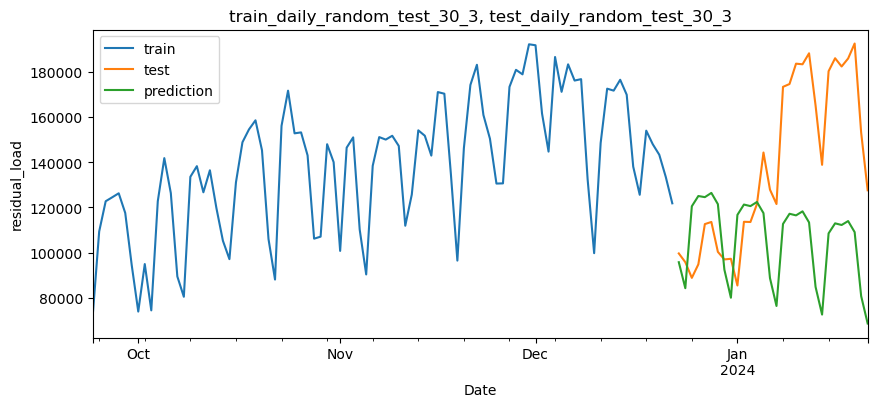

AME:42444.38
RMSE:50522.94
MAPE:42.31%


In [113]:
#model training and forecasting
model_sarima_daily_30_3 = auto_arima(train_daily_random_test_30_3, m = 7)
print(model_sarima_daily_30_3.summary())

#predict the next seven days
prediction_sarima_daily_30_3 = model_sarima_daily_30_3.predict(n_periods = len(test_daily_random_test_30_3))

#model prediction plot
model_prediction(train_daily_random_test_30_3[-90:], test_daily_random_test_30_3, prediction_sarima_daily_30_3, 'train_daily_random_test_30_3, test_daily_random_test_30_3')

## 7 days forecasts:
- data set 1:
  - AME:10638.00
  - RMSE:14008.87
  - MAPE:6.54%
- data set 2:
  - AME:9721.21
  - RMSE:13199.02
  - MAPE:7.07%
- data set 3:
  - AME:58189.54
  - RMSE:60498.20
  - MAPE:140.69%
- data set 4:
  - AME:17562.05
  - RMSE:20023.55
  - MAPE:15.01%

## 30 days forecasts:
- data set 1:
  - AME:41016.14
  - RMSE:52146.82
  - MAPE:19.96%
- data set 2:
  - AME:18849.74
  - RMSE:22322.91
  - MAPE:13.86%
- data set 3:
  - AME:85543.55
  - RMSE:89993.41
  - MAPE:921.41%
- data set 4:
  - AME:42444.38
  - RMSE:50522.94
  - MAPE:42.31%

## Observation: longer forecasts (30 days) perform worse than shorter forecasts (7 days)

# Cross Validation with order = (0, 1, 1), seasonal_order = (1, 0, 1, 7)

In [115]:
model_cv = ARIMA(order = (0, 1, 1), seasonal_order = (1, 0, 1, 7))

In [117]:
cv = model_selection.RollingForecastCV(h = 7, step = 4, initial = df.shape[0] - 180)

In [121]:
cv_score = model_selection.cross_val_score(model_cv,
                                           y = df_daily['residual_load'],
                                           scoring = 'mean_squared_error',
                                           cv = cv,
                                           verbose = 1,
                                           error_score = 1000000000)

C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [131]:
rmse = np.sqrt(cv_score.mean())
print(f'The RMSE is {int(rmse)}')

The RMSE is 23400


# Cross Validation with order = (0, 1, 0), seasonal_order = (2, 0, 0, 7)

In [162]:
model_cv_1 = ARIMA(order = (0, 1, 0), seasonal_order = (2, 0, 0, 7))

In [164]:
cv_score_1 = model_selection.cross_val_score(model_cv_1,
                                           y = df_daily['residual_load'],
                                           scoring = 'mean_squared_error',
                                           cv = cv,
                                           verbose = 1,
                                           error_score = 1000000000)

In [166]:
rmse_1 = np.sqrt(cv_score_1.mean())
print(f'The RMSE is {int(rmse_1)}')

The RMSE is 23459


- The RMSE difference between the two parameters is insignificant
- RMSE (order = (0, 1, 1), seasonal_order = (1, 0, 1, 7)  : 23400
- RMSE (order = (0, 1, 0), seasonal_order = (2, 0, 0, 7)) : 23459

# Rolling Forecast to find best model parameters

In [196]:
#Defining paramaters
param_grid = {'p':[0,1],
              'd':[0,1],
              'q':[1,2],
              'P':[1,2],
              'D':[0,1],
              'Q':[1,2]}
grid = ParameterGrid(param_grid)
len(list(grid))

64

In [198]:
#Parameter Tuning Loop
rmse_list = []

for params in grid:
#Build the model with a set of parameters 
    model_CV = ARIMA(order = (params['p'], params['d'], params['q']), 
                 seasonal_order = (params['P'], params['D'], params['Q'], 7))

#Evaluate the model
    CV = model_selection.RollingForecastCV(h = 7, step = 4, initial = df.shape[0] - 180)

#inputs for the CV
    cv_SCORE = model_selection.cross_val_score(model_CV, 
                                               y = df_daily['residual_load'], 
                                               scoring = 'mean_squared_error', 
                                               cv = CV, 
                                               verbose = 1, 
                                               error_score = 10000000000000)

#store the error
    RMSE = np.sqrt(cv_SCORE.mean())
    rmse_list.append(RMSE)

C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

ValueError: Input contains NaN.

In [204]:
rmse_list 

[66403.70749644165,
 24583.78033296022,
 20651.11874698378,
 19585.48953102472,
 23400.259576631488,
 18820.080220480726,
 21446.03460782874,
 18778.44656312164,
 22104.294410483344,
 22109.219392049257,
 21485.638829075542,
 20158.33057791052,
 20618.167996218133,
 18875.855784255848,
 18678.09063996495,
 18805.685704971787,
 21924.448890316122]

In [220]:
#
tuning_results  = pd.DataFrame(grid)
tuning_results = tuning_results.loc[:16]
tuning_results['rmse'] = rmse_list
tuning_results = tuning_results[['p', 'd', 'q', 'P', 'D', 'Q', 'rmse']]

In [222]:
tuning_results

,p,d,q,P,D,Q,rmse
0,0,0,1,1,0,1,66403.707496
1,0,0,2,1,0,1,24583.780333
2,1,0,1,1,0,1,20651.118747
3,1,0,2,1,0,1,19585.489531
4,0,1,1,1,0,1,23400.259577
5,0,1,2,1,0,1,18820.080220
6,1,1,1,1,0,1,21446.034608
7,1,1,2,1,0,1,18778.446563
8,0,0,1,1,0,2,22104.294410
9,0,0,2,1,0,2,22109.219392


In [279]:
#indentify best parameters
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()].transpose()
best_params

,14
p,1.00000
d,1.00000
q,1.00000
P,1.00000
D,0.00000
Q,2.00000
rmse,18678.09064


- best parameters : order=(1, 1, 1), seasonal_order=(1, 0, 2, 7)
- RMSE : 18678

In [40]:
#fit best parameters into model and reevalute forecast performance
model = SARIMAX(
    train_daily_7,
    order=(1, 1, 1),          # (p, d, q)
    seasonal_order=(1, 0, 2, 7),  # (P, D, Q, seasonal_period)
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                          residual_load   No. Observations:                 3681
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood              -40999.059
Date:                                Sat, 29 Mar 2025   AIC                          82010.117
Time:                                        11:27:44   BIC                          82047.355
Sample:                                    01-01-2015   HQIC                         82023.376
                                         - 01-28-2025                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3605      0.090      3.991      0.000       0.183       0.537
ma.L1         -0.6916      0.068    -10.236      0.000      -0.824      -0.559
ar.S.L7        0.9970      0.006    180.787      0.000       0.986       1.008
ma.S.L7       -0.8761      0.053    -16.674      0.000      -0.979      -0.773
ma.S.L14       0.0130      0.054      0.239      0.811      -0.094       0.120
sigma2      6.409e+08   4.63e-11   1.38e+19      0.000    6.41e+08    6.41e+08
===================================================================================
Ljung-Box (L1) (Q):                  10.72   Jarque-Bera (JB):              1348.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.64
Prob(H) (two-sided):                  0.28   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+34. Standard errors may be unstable.
"""

In [42]:
forecast = results.get_forecast(steps = 7)
prediction = forecast.predicted_mean

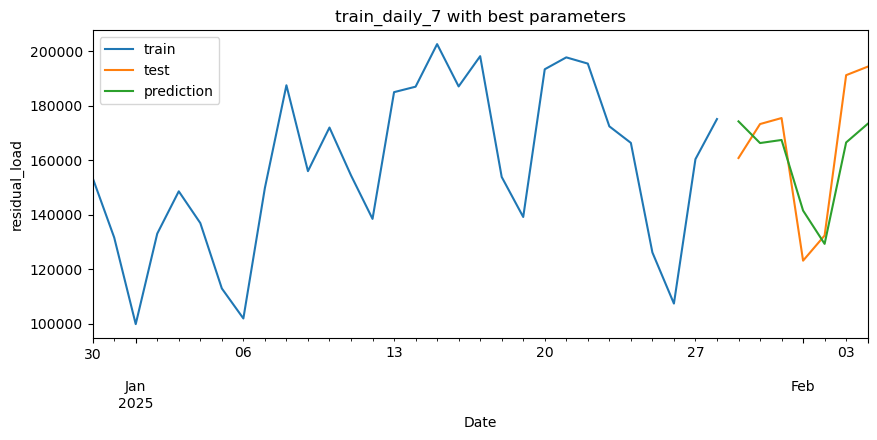

AME:13661.29
RMSE:15550.05
R2:0.06
MAPE:8.44%


In [44]:
model_prediction(train_daily_7[-30:], test_daily_7, prediction,'train_daily_7 with best parameters')

In [46]:
model = SARIMAX(
    train_daily_random_test_7_1,
    order=(1, 1, 1),          # (p, d, q)
    seasonal_order=(1, 0, 2, 7),  # (P, D, Q, seasonal_period)
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

In [47]:
forecast = results.get_forecast(steps = 7)
prediction = forecast.predicted_mean

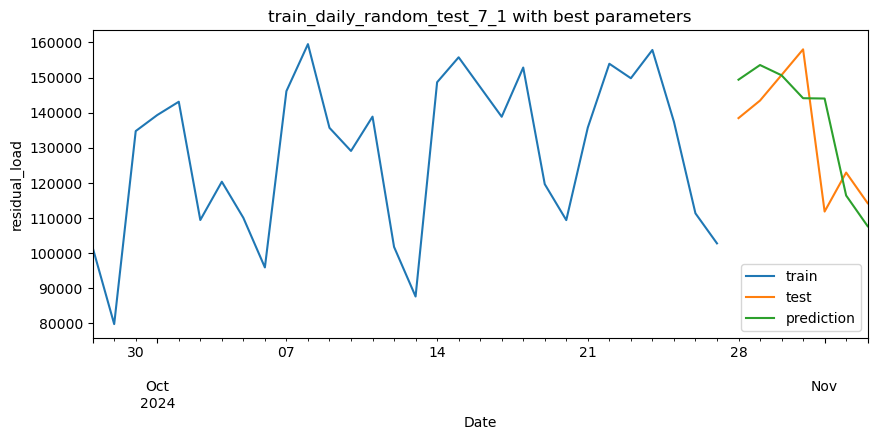

AME:11473.28
RMSE:14816.73
R2:0.23
MAPE:8.24%


In [48]:
model_prediction(train_daily_random_test_7_1[-30:], test_daily_random_test_7_1, prediction,'train_daily_random_test_7_1 with best parameters')

In [56]:
model = SARIMAX(
    train_daily_random_test_7_2,
    order=(1, 1, 1),          # (p, d, q)
    seasonal_order=(1, 0, 2, 7),  # (P, D, Q, seasonal_period)
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

In [58]:
forecast = results.get_forecast(steps = 7)
prediction = forecast.predicted_mean

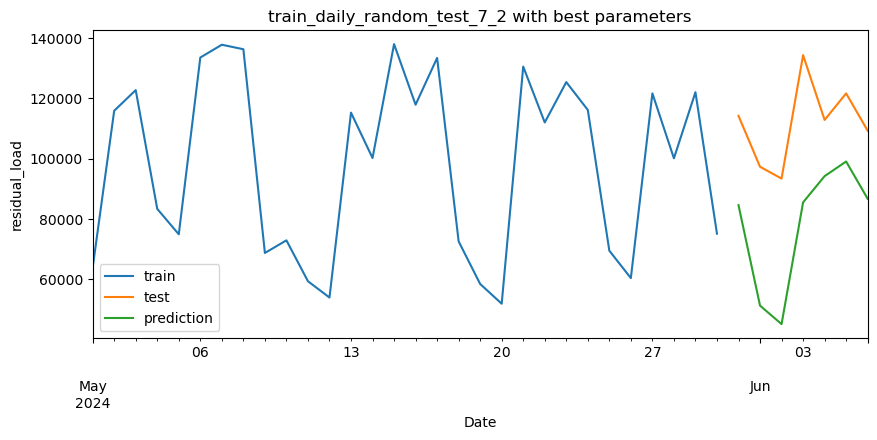

AME:33805.84
RMSE:36024.63
R2:-2.39
MAPE:51.10%


In [60]:
model_prediction(train_daily_random_test_7_2[-30:], test_daily_random_test_7_2, prediction,'train_daily_random_test_7_2 with best parameters')

In [62]:
model = SARIMAX(
    train_daily_random_test_7_3,
    order=(1, 1, 1),          # (p, d, q)
    seasonal_order=(1, 0, 2, 7),  # (P, D, Q, seasonal_period)
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

In [64]:
forecast = results.get_forecast(steps = 7)
prediction = forecast.predicted_mean

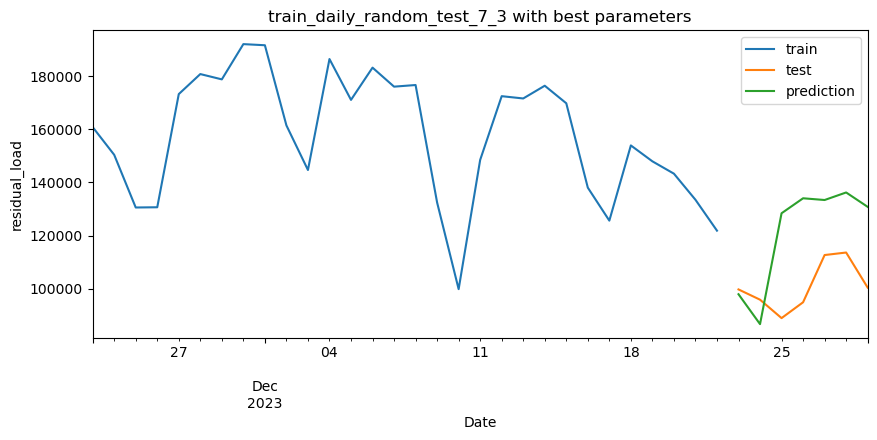

AME:23332.41
RMSE:26837.13
R2:-1.09
MAPE:18.25%


In [66]:
model_prediction(train_daily_random_test_7_3[-30:], test_daily_random_test_7_3, prediction,'train_daily_random_test_7_3 with best parameters')

In [382]:
model_cv = ARIMA(order = (1, 1, 1), seasonal_order = (1, 0, 2, 7))

In [70]:
cv = model_selection.RollingForecastCV(h = 7, step = 4, initial = df.shape[0] - 180)

In [386]:
cv_score = model_selection.cross_val_score(model_cv,
                                           y = df_daily['residual_load'],
                                           scoring = 'mean_absolute_error',
                                           cv = cv,
                                           verbose = 1,
                                           error_score = 1000000000)

C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [398]:
AME = cv_score.mean()
print(f'The AME is {int(AME)}')

The AME is 14681


In [400]:
cv_score = model_selection.cross_val_score(model_cv,
                                           y = df_daily['residual_load'],
                                           scoring = 'smape',
                                           cv = cv,
                                           verbose = 1,
                                           error_score = 1000000000)

C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sinyi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [412]:
MAPE = cv_score.mean()
print(f'The MAPE is {(MAPE):.2f}')

The MAPE is 11.35


# Overview

# 7-days vs 30-days forecasts

In [451]:
from IPython.display import display, HTML

# Style for consistent formatting
style = """
<style>
    .image-row {
        display: flex;
        justify-content: space-between;
        margin-bottom: 20px;
    }
    .image-pair {
        width: 49%;
        box-shadow: 0 4px 8px rgba(0,0,0,0.1);
        border-radius: 4px;
    }
    .section-title {
        font-family: Arial, sans-serif;
        font-size: 18px;
        font-weight: bold;
        margin: 15px 0 10px 0;
        color: white;
        text-align: center;
    }
</style>
"""

# 7-Day Forecast
display(HTML(style + """
<div class="section-title">7-Day Forecast</div>
<div class="image-row">
    <img class="image-pair" src='7days_1.png'>
    <img class="image-pair" src='7days_2.png'>
</div>
<div class="image-row">
    <img class="image-pair" src='7days_3.png'>
    <img class="image-pair" src='7days_4.png'>
</div>
"""))

# 30-Day Forecast
display(HTML("""
<div class="section-title">30-Day Forecast</div>
<div class="image-row">
    <img class="image-pair" src='30days_1.png'>
    <img class="image-pair" src='30days_2.png'>
</div>
<div class="image-row">
    <img class="image-pair" src='30days_3.png'>
    <img class="image-pair" src='30days_4.png'>
</div>
"""))

# Best Param Forecast
- best parameters : order = (1, 1, 1), seasonal_order = (1, 0, 2, 7)
- MAE : 14681
- RMSE : 18678
- MAPE : 11.35%

In [457]:
display(HTML("""
<div class="section-title">Best Param Forecast</div>
<div class="image-row">
    <img class="image-pair" src='bestparam_1.png'>
    <img class="image-pair" src='bestparam_2.png'>
</div>
<div class="image-row">
    <img class="image-pair" src='bestparam_3.png'>
    <img class="image-pair" src='bestparam_4.png'>
</div>
"""))